In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev

warnings.filterwarnings('ignore')

In [2]:
otm_fp = '/home/mremington/Documents/therma_sim/ibutton_data_analysis/OTM_Main_Database.csv'
otm_data = pd.read_csv(otm_fp, index_col=0)
otm_data['Date'] = pd.to_datetime(otm_data['Date'])
otm_data = otm_data.drop(columns=['Lat', 'Long'])
microhabitat = []
for index, row in otm_data.iterrows():
    if row['OTM_ID']=='Air Temperature':
        micro = 'Air_Temperature'
    else:
        micro = row['Microhabitat']
    microhabitat.append(micro)
otm_data['Microhabitat'] = microhabitat
otm_data = otm_data.dropna(subset=['Microhabitat']).sort_values(by=['Study_Site', 'Date'], ascending=True)
otm_data.head()



,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,OTM_ID,file_name,Microhabitat,season
0,2022-06-17 23:00:01,C,17.663,2022,6,17,23,0,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring
1,2022-06-18 00:10:01,C,17.663,2022,6,18,0,10,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring
2,2022-06-18 01:20:01,C,17.163,2022,6,18,1,20,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring
3,2022-06-18 02:30:01,C,17.163,2022,6,18,2,30,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring
4,2022-06-18 03:40:01,C,16.662,2022,6,18,3,40,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring


In [20]:
nan_microhabitat_rows = otm_data[otm_data['Microhabitat'].isna()]
nan_microhabitat_rows.head()#['file_name'].unique()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,OTM_ID,file_name,Microhabitat,season
42912,2022-06-17 23:00:01,C,20.121,2022,6,17,23,0,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42913,2022-06-18 00:10:01,C,19.120,2022,6,18,0,10,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42914,2022-06-18 01:20:01,C,19.120,2022,6,18,1,20,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42915,2022-06-18 02:30:01,C,17.617,2022,6,18,2,30,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42916,2022-06-18 03:40:01,C,17.116,2022,6,18,3,40,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring


In [3]:
spark = SparkSession.builder.appName("PandasToSparkPivot").getOrCreate()
spark_df = spark.createDataFrame(otm_data)

# Pivot the Spark DataFrame
otm_data = spark_df.groupBy('year', 'month',
                          'day','hour', 'Study_Site').pivot("Microhabitat").agg(
    mean("Temperature").alias("mean_Temperature"),
    stddev("Temperature").alias("stddev_Temperature")
)


# Display the pivoted Spark DataFrame
otm_data = otm_data.toPandas()
otm_data = otm_data.sort_values(by=['Study_Site', 'year', 'month', 'day', 'hour'], ascending=True).reset_index(drop=True)

otm_data.head()

,year,month,day,hour,Study_Site,Air_Temperature_mean_Temperature,Air_Temperature_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature
0,2022,6,17,23,Canada,22.580,NaN,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000
1,2022,6,18,0,Canada,20.579,NaN,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800
2,2022,6,18,1,Canada,21.079,NaN,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721
3,2022,6,18,2,Canada,19.077,NaN,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970
4,2022,6,18,3,Canada,18.077,NaN,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007


In [6]:
otm_data['DateTime'] = pd.to_datetime(otm_data[['year', 'month', 'day', 'hour']])

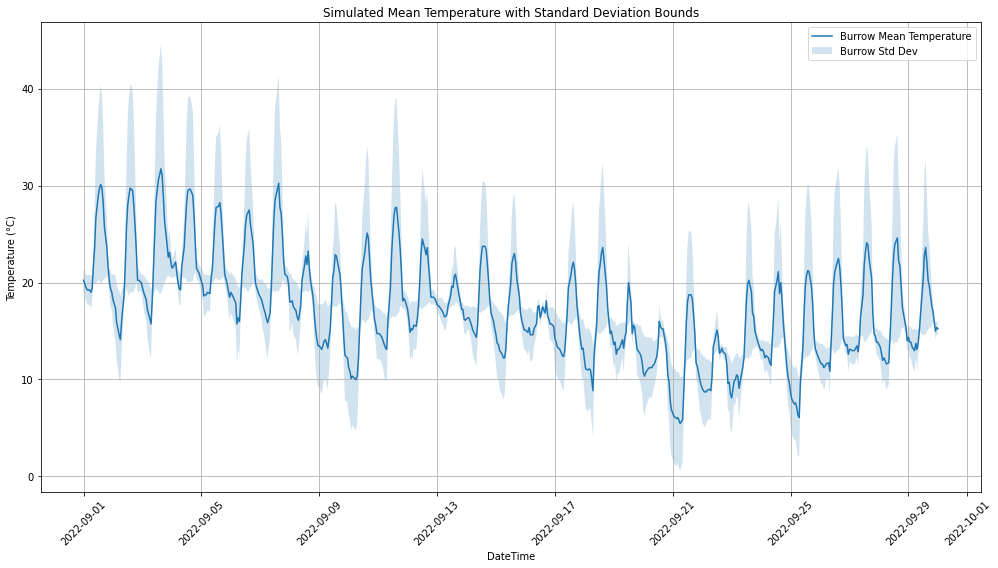

In [16]:
def plot_time_series_with_std(df, mean_col, std_col, label):
    mean = df[mean_col]
    std = df[std_col]
    plt.plot(df['DateTime'], mean, label=f"{label} Mean Temperature")
    plt.fill_between(df['DateTime'], mean - std, mean + std, alpha=0.2, label=f"{label} Std Dev")
    
start_date = '2022-09-01'
end_date = '2022-09-30'

filtered_df = otm_data[(otm_data['Study_Site'] == 'Canada') & 
                 (otm_data['DateTime'] >= start_date) & 
                 (otm_data['DateTime'] <= end_date)]

plt.figure(figsize=(14, 8))

# Plotting the simulated data
plot_time_series_with_std(filtered_df, 'Burrow_mean_Temperature', 'Burrow_stddev_Temperature', 'Burrow')
#plot_time_series_with_std(filtered_df, 'Open_mean_Temperature', 'Open_stddev_Temperature', 'Open')
#plot_time_series_with_std(filtered_df, 'Shrub_mean_Temperature', 'Shrub_stddev_Temperature', 'Shrub')

plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Mean Temperature with Standard Deviation Bounds')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()